In [1]:
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p9
import numpy as np
import calplot
import matplotlib.font_manager
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
import joblib


In [2]:
df = pd.read_csv("ebay_iphone11_new.csv")
print(df.head)

<bound method NDFrame.head of                                                  iPhone  Condition      Price  \
0                                          Shop on eBay  Brand New     $20.00   
1                                          Shop on eBay  Brand New     $20.00   
2     Apple iPhone 11 64GB Fully Unlocked GSM/CDMA -...  Pre-Owned  C $268.99   
3     Apple iPhone 11 - 64GB - Factory Unlocked - Go...  Pre-Owned  C $270.23   
4       Apple iPhone 11 A2111 Cricket Only 64GB Black C  Pre-Owned  C $224.05   
...                                                 ...        ...        ...   
6844                                       Shop on eBay  Brand New     $20.00   
6845                                       Shop on eBay  Brand New     $20.00   
6846                                       Shop on eBay  Brand New     $20.00   
6847                                       Shop on eBay  Brand New     $20.00   
6848                                       Shop on eBay  Brand New     $20.00  

In [3]:
## Cleaning iPhone column

## Removing "Shop on eBay" text containing rows on start, end and sometimes multiple times in header in pages
df = df[~df['iPhone'].str.contains('Shop on eBay')]

# Count the number of occurrences of "GB" in each row
gb_counts = df['iPhone'].str.count('GB')

# Filter out rows where the count is greater than 1
rows_with_more_than_one_gb = df[gb_counts > 1]

# Print the number of rows
print("Number of rows with more than 1 'GB' text:", len(rows_with_more_than_one_gb))

df = df[df['iPhone'].str.count('GB') == 1]

# Removing garbage text which is not a listing
df = df[df['iPhone'].str.contains('iPhone 11')]

# Removing Cracked and broken listings
df = df[~df['iPhone'].str.contains('cracked|broken|crack|No Face ID|Box Only', case=False, na=False)]


Number of rows with more than 1 'GB' text: 1073


In [4]:
df['iPhone_lower'] = df['iPhone'].str.lower()
contains_case = df['iPhone_lower'].str.contains('case', na=False)

# Count the number of rows that contain the word "case"
count_case = contains_case.sum()

print(f"Number of rows containing the word 'case': {count_case}")

Number of rows containing the word 'case': 3


In [5]:
## Cleaning Price Column
df['Price'] = df['Price'].str.replace('C', '').str.replace('$', '')
# Convert to numeric and identify non-numeric rows
df['Price_numeric'] = pd.to_numeric(df['Price'], errors='coerce')

# Count non-numeric rows in Price column
non_numeric_price_count = df['Price_numeric'].isna().sum()
print("Number of rows with non-numeric values in Price column:", non_numeric_price_count)

# Remove rows with non-numeric values in Price column
df = df.dropna(subset=['Price_numeric'])

# Drop the Price_numeric column as it's no longer needed
df = df.drop(columns=['Price_numeric'])

df['Price'] = df['Price'].astype(float)

Number of rows with non-numeric values in Price column: 88


In [6]:
# Cleaning Shipping Column
# Replace "Free shipping" with 0
df['Shipping'] = df['Shipping'].str.replace('Free shipping', '0')

# Remove "+C $" from the beginning of the text
df['Shipping'] = df['Shipping'].str.replace(r'^\+C \$', '', regex=True)

# Remove any text after the numeric value (such as "shipping" or "shipping estimate")
df['Shipping'] = df['Shipping'].str.replace(r'\D+$', '', regex=True)

# Remove extra spaces
df['Shipping'] = df['Shipping'].str.strip()

# Remove "shipping" and "estimate" strings
df['Shipping'] = df['Shipping'].str.replace('shipping', '', case=False)
df['Shipping'] = df['Shipping'].str.replace('estimate', '', case=False)
df['Shipping'] = df['Shipping'].str.replace(' ', '')
df['Shipping'] = df['Shipping'].str.replace('nan', '0')
df['Shipping'] = df['Shipping'].fillna(0)
df['Shipping'] = df['Shipping'].replace('', '0')
df['Shipping'] = df['Shipping'].astype(float)

In [7]:
try:
    df['Shipping'] = df['Shipping'].astype(float)
except ValueError:
    # Print rows with non-convertible values
    print(df[pd.to_numeric(df['Shipping'], errors='coerce').isna()]['Shipping'])

In [8]:
# Convert string values to float, ignoring errors
df['Shipping'] = pd.to_numeric(df['Shipping'], errors='coerce')

# Now, if you want to print the rows that couldn't be converted to float due to errors:
error_rows = df[df['Shipping'].isna()]
print("\nRows with Errors in Shipping Column:")
print(error_rows)


Rows with Errors in Shipping Column:
Empty DataFrame
Columns: [iPhone, Condition, Price, Seller_type, Seller, Shipping, Seller_review, Seller_location, iPhone_lower]
Index: []


In [9]:
## Cleaning and processing Seller_location Column
# Remove "from " at the start of the rows
df['Seller_location'] = df['Seller_location'].str.replace(r'^from ', '', regex=True)

# Fill NaN values with "Canada"
df['Seller_location'] = df['Seller_location'].fillna('Canada')


In [10]:
# Cleaning and dividing Seller column
# Extract the seller name, number of reviews, and rating using a refined regular expression
df[['Seller_name', 'Seller_reviews', 'Seller_rating']] = df['Seller'].str.extract(r'^(.*?) \(([\d,]+)\) ([\d.]+%)$')

# Remove commas from seller reviews and make it float
df['Seller_reviews'] = df['Seller_reviews'].str.replace(',', '').astype(float)

# Convert Seller_rating column to string type
df['Seller_rating'] = df['Seller_rating'].astype(str)

# Remove the "%" symbol from Seller_rating
df['Seller_rating'] = df['Seller_rating'].str.replace('%', '')

# Convert Seller_rating column to float type
df['Seller_rating'] = df['Seller_rating'].astype(float)


In [11]:
##  Processing Seller_review columns
# Rename the column from "Seller_review" to "Seller_stars"
df.rename(columns={'Seller_review': 'Seller_stars'}, inplace=True)

# Print the unique values in the "Seller_stars" column
print("Unique values in Seller_stars column:", df['Seller_stars'].unique())

# Replace NaN values with 0 and convert the "Seller_stars" column to float
df['Seller_stars'] = df['Seller_stars'].fillna(0).astype(float)

Unique values in Seller_stars column: [5.  4.  nan 4.5 3.5 3.  1. ]


In [12]:
## Removing irrelevant columns
df = df.drop(columns=['Seller', 'Seller_type'])

In [13]:
## To divide iPhones by models and carriers we need to print the countries so that we can search their Carriers trhough regex

print("Unique values in Seller_location column", df['Seller_location'].unique())

# Converting Croatia for ease
df['Seller_location'] = df['Seller_location'].replace('Croatia, Republic of', 'Croatia')


Unique values in Seller_location column ['Canada' 'United States' 'Romania' 'China' 'Greece' 'Hong Kong'
 'Slovenia' 'Israel' 'Australia' 'Japan' 'Portugal' 'Singapore' 'Italy'
 'United Kingdom']


In [14]:
## Processing iPhone column
# Extract storage information and remove it from the iPhone column
df['Storage'] = df['iPhone'].str.extract(r'(\d+\s*GB)', expand=False).str.replace(' GB', '').str.replace('GB', '')

# Dropping devices with storage options not available
df = df.dropna(subset=['Storage'])

# Extracting colors
# Define colors for each iPhone model
colors_11 = ['Black', 'White', 'Green', 'Purple', 'Red', 'Yellow']
colors_11_pro = ['Gold', 'Space Gray', 'Silver', 'Midnight Green', 'Space Grey']
colors_11_pro_max = ['Gold', 'Silver', 'Space Gray', 'Midnight Green', 'Space Grey']

# Combine all colors into a single list for extraction
all_colors = colors_11 + colors_11_pro + colors_11_pro_max

# Create a regex pattern to extract colors
color_pattern = '|'.join(all_colors)

# Extract colors regardless of case and create the "Color" column
df['Color'] = df['iPhone'].str.extract(f'({color_pattern})', flags=re.IGNORECASE, expand=False)

# Standardize the color names to match the defined colors
df['Color'] = df['Color'].str.title()


In [15]:
## Separating iPhone models
def extract_model(iphone_name):
    iphone_name = iphone_name.lower()
    if 'pro max' in iphone_name:
        return '11 Pro Max'
    elif 'pro' in iphone_name:
        return '11 Pro'
    elif '11' in iphone_name:
        return '11'

# Apply the function to create the Model column
df['Model'] = df['iPhone'].apply(extract_model)

In [16]:
## Carrier locked phones
# Count unlocked phones (case insensitive)
unlocked_count = df['iPhone'].str.contains(r'\bunlocked\b', case=False, na=False).sum()

# Filter out rows containing "unlocked"
df_filtered = df[~df['iPhone'].str.contains(r'\bunlocked\b', case=False, na=False)]

# Count locked phones (case insensitive)
locked_count = df_filtered['iPhone'].str.contains(r'\blocked\b', case=False, na=False).sum()

# Print the counts
print("Number of rows with 'unlocked' in iPhone column:", unlocked_count)
print("Number of rows with 'locked' in iPhone column:", locked_count)

## checking the df_filtered all phones in their are locked so we make carrier-status column
def add_carrier_status(df):
  # Create a new column named "Carrier_Status"
  df['Carrier_Status'] = 'Locked'

  # Update rows with "unlocked" in iPhone column to "Unlocked"
  df.loc[df['iPhone'].str.contains(r'\bunlocked\b', case=False, na=False), 'Carrier_Status'] = 'Unlocked'

  return df

# Apply the function to modify the DataFrame
df = add_carrier_status(df.copy())

Number of rows with 'unlocked' in iPhone column: 1686
Number of rows with 'locked' in iPhone column: 100


In [17]:
# Count the number of rows with NaN in the Storage column
nan_count = df['Color'].isna().sum()

# Print the count of rows with NaN in the Storage column
print("Number of rows with NaN in Color column:", nan_count)

Number of rows with NaN in Color column: 576


In [18]:
mean_price = df['Price'].mean()

mean_price = df['Price'].median()
print(mean_price)


347.21


In [19]:
# Calculate total price
df['Total_Price'] = df['Price'] + df['Shipping']

In [20]:
# Cleaning all empty rows
df = df.dropna(subset=df.columns.difference(['Color']), how='any')

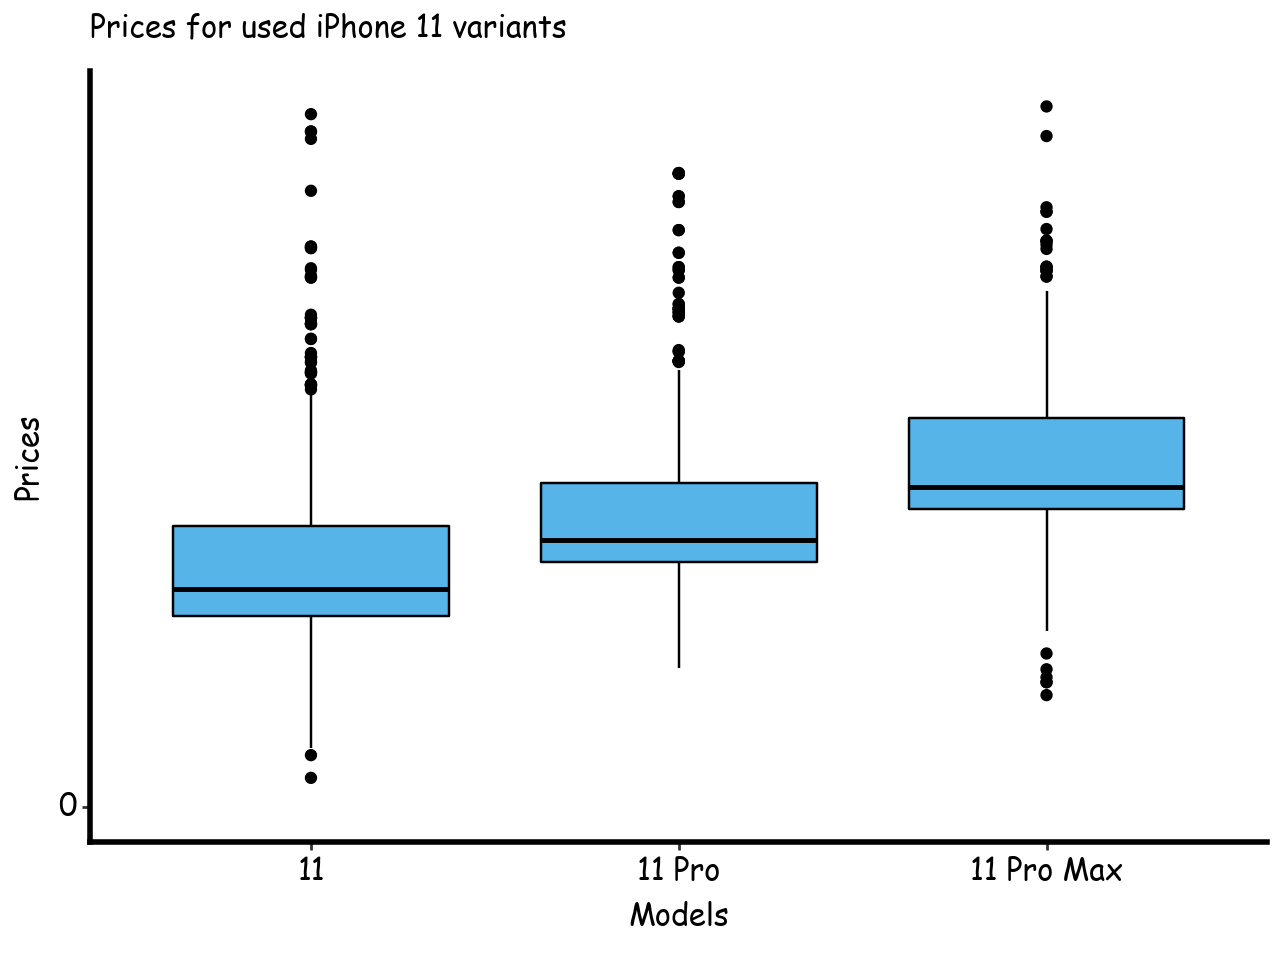

In [21]:

# Create the boxplot
boxplot = (
    p9.ggplot(df, p9.aes(x='Model', y='Total_Price'))
    + p9.geom_boxplot(color="black", fill="#56B4E9")  # Box color and fill
    + p9.xlab("Models")  # X-axis label
    + p9.ylab("Prices")  # Y-axis label
    + p9.scale_y_continuous(breaks=np.arange(0, max(df['Total_Price'])+5000, 5000),  # Adjust breaks based on your data
                             limits=[0, max(df['Total_Price'])])  # Adjust limits based on your data
    + p9.ggtitle("Prices for used iPhone 11 variants")  # Title
    + p9.theme(
        axis_line=p9.element_line(size=2, color="black"),  # Axis line properties
        panel_grid_major=p9.element_blank(),  # Major grid lines
        panel_grid_minor=p9.element_blank(),  # Minor grid lines
        panel_border=p9.element_blank(),  # Panel border
        panel_background=p9.element_blank(),  # Panel background
        plot_title=p9.element_text(font="cursive"),  # Title font properties
        text=p9.element_text(font="cursive"),  # Text font properties
        axis_text_x=p9.element_text(color="black"),  # X-axis text color
        axis_text_y=p9.element_text(color="black"),  # Y-axis text color
    )
)

# Display the boxplot
print(boxplot)

In [22]:
## Checking for very high and very low prices in iPhone 11
# Calculate Total Price
df['Total_Price'] = df['Price'] + df['Shipping']

# Print unique values in Condition column
unique_conditions = df['Condition'].unique()
print("Unique values in Condition column:", unique_conditions)

# Sort the DataFrame by Total_Price in ascending order and select the bottom 100 rows
bottom_100_prices = df.nsmallest(100, 'Total_Price')

# Sort the DataFrame by Total_Price in descending order and select the top 100 rows
top_100_prices = df.nlargest(100, 'Total_Price')

# Count the occurrences of conditions in the bottom 100 prices
bottom_condition_counts = bottom_100_prices['Condition'].value_counts()
print("\nCondition counts in the bottom 100 Total Prices:")
print(bottom_condition_counts)

# Count the occurrences of conditions in the top 100 prices
top_condition_counts = top_100_prices['Condition'].value_counts()
print("\nCondition counts in the top 100 Total Prices:")
print(top_condition_counts)


Unique values in Condition column: ['Pre-Owned' 'Good - Refurbished' 'Open Box' 'Very Good - Refurbished'
 'Parts Only' 'Excellent - Refurbished' 'New (Other)' 'Brand New']

Condition counts in the bottom 100 Total Prices:
Condition
Parts Only    78
Pre-Owned     21
Open Box       1
Name: count, dtype: int64

Condition counts in the top 100 Total Prices:
Condition
Pre-Owned                  46
Brand New                  34
New (Other)                12
Excellent - Refurbished     3
Good - Refurbished          3
Very Good - Refurbished     2
Name: count, dtype: int64


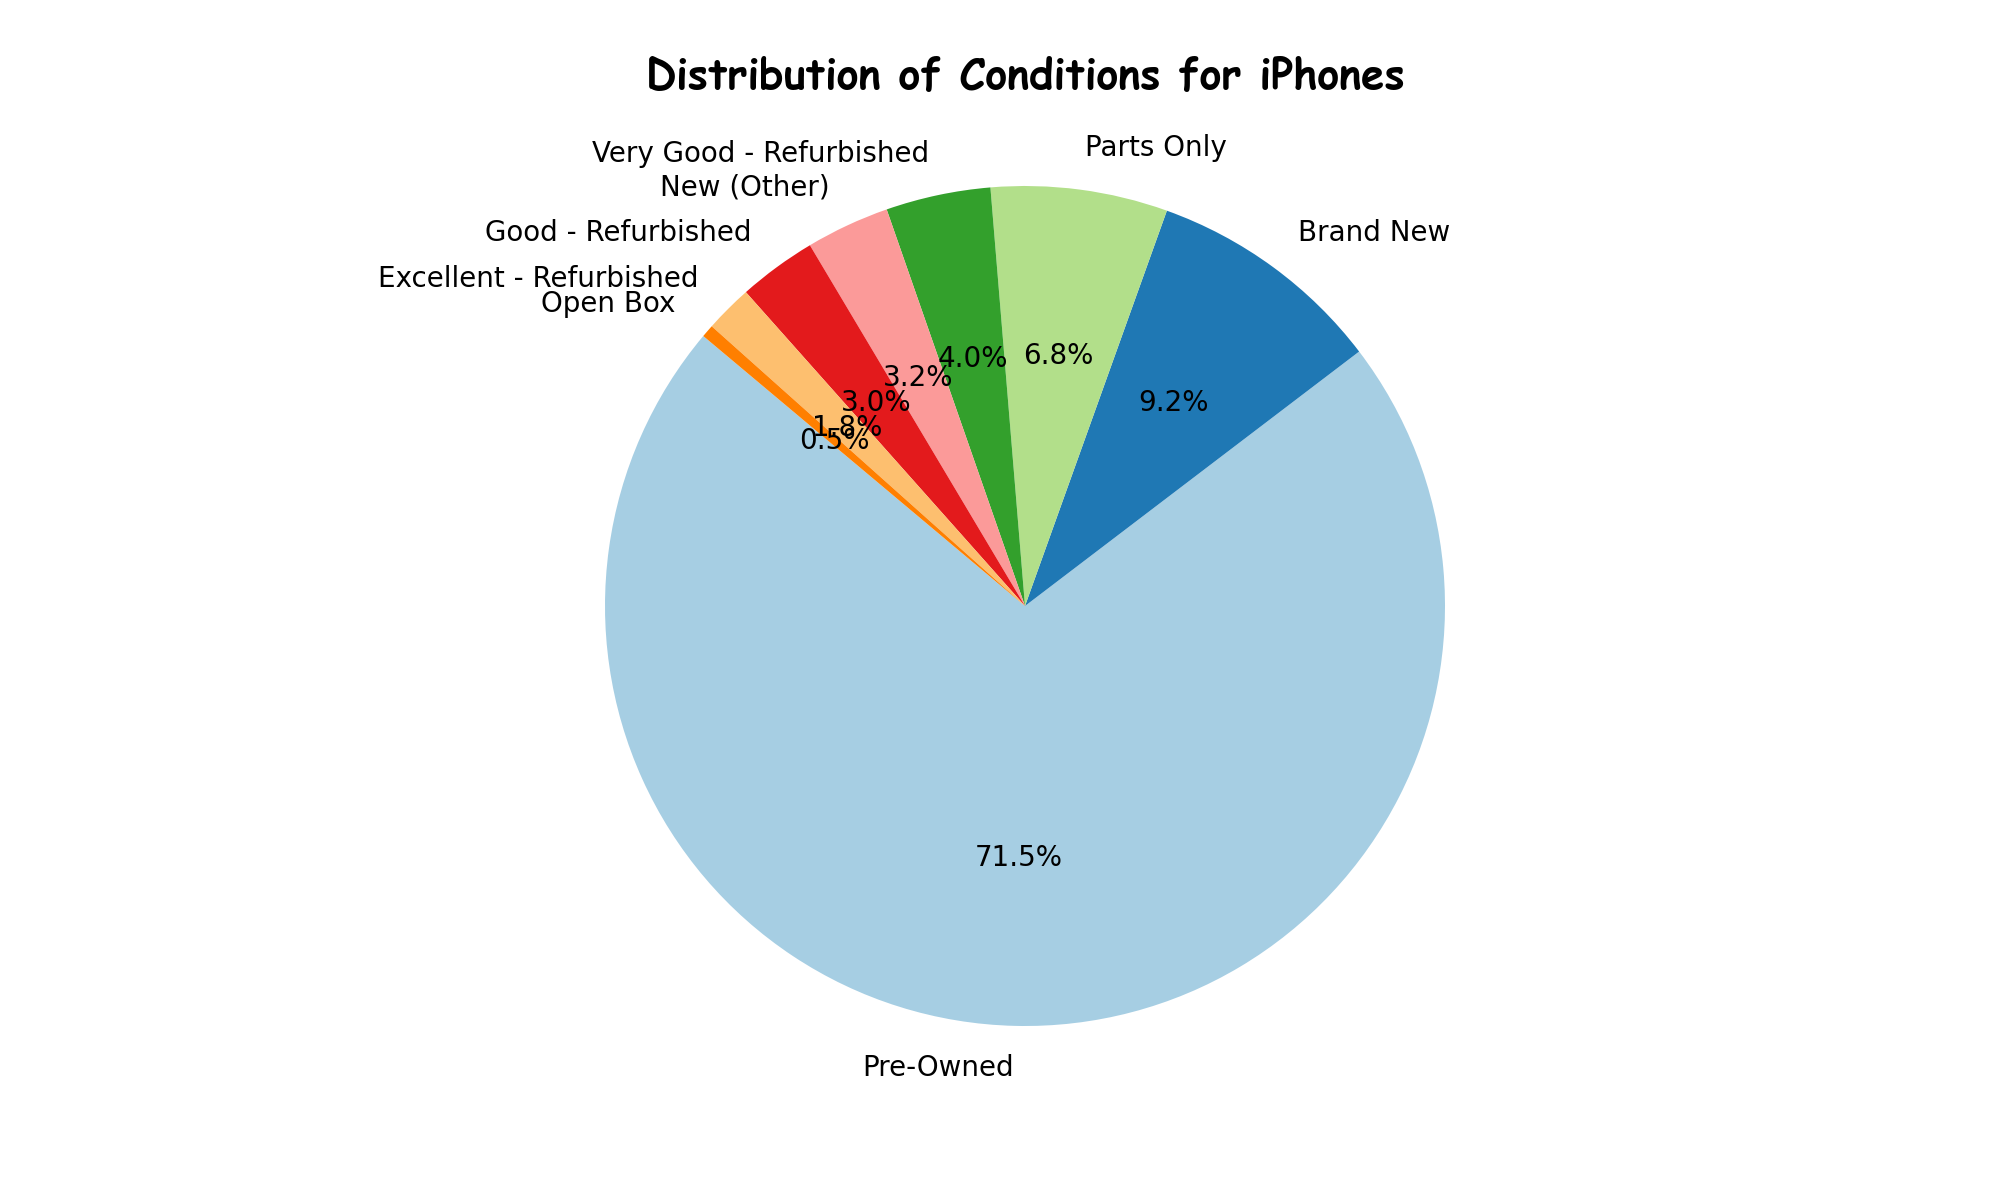

In [23]:
## Condition of devices
# Count the occurrences of each condition
condition_counts = df['Condition'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(condition_counts, labels=condition_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Conditions for iPhones', fontdict={'fontsize': 15, 'fontweight': 'bold', 'fontname': 'cursive'}, pad=20)
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

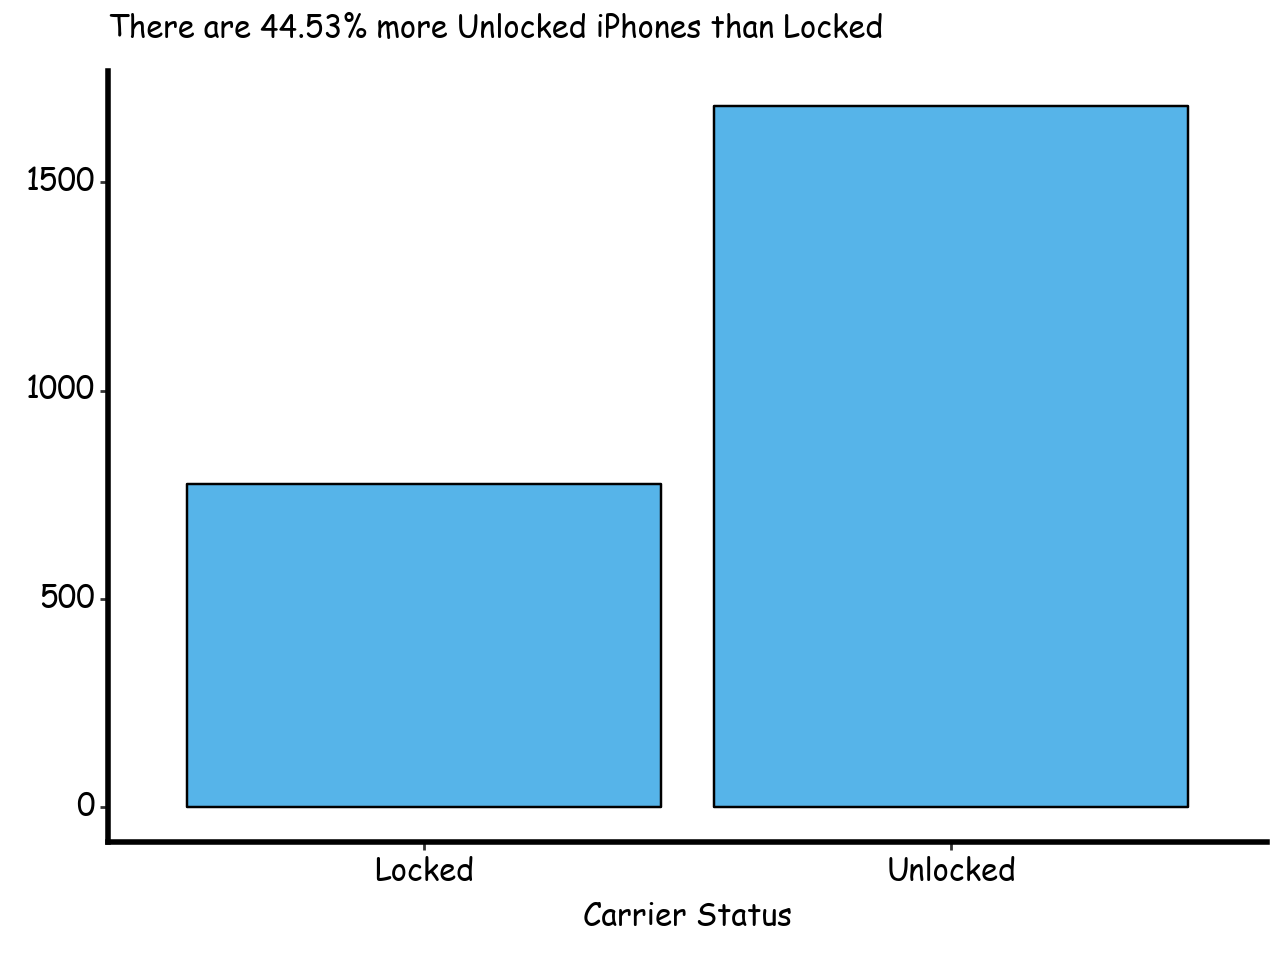

In [24]:
# Count the occurrences of each Carrier_Status
carrier_status_counts = df['Carrier_Status'].value_counts().reset_index()
carrier_status_counts.columns = ['Carrier_Status', 'Count']

# Create the bar graph
bar_graph = (
    p9.ggplot(carrier_status_counts, p9.aes(x='Carrier_Status', y='Count'))
    + p9.geom_bar(stat='identity', color="black", fill="#56B4E9")  # Bar color and fill
    + p9.xlab("Carrier Status")  # X-axis label
    + p9.ylab("")  # Y-axis label
    + p9.ggtitle("There are 44.53% more Unlocked iPhones than Locked")  # Title
    + p9.theme(
        axis_line=p9.element_line(size=2, color="black"),  # Axis line properties
        panel_grid_major=p9.element_blank(),  # Major grid lines
        panel_grid_minor=p9.element_blank(),  # Minor grid lines
        panel_border=p9.element_blank(),  # Panel border
        panel_background=p9.element_blank(),  # Panel background
        plot_title=p9.element_text(font="cursive"),  # Title font properties
        text=p9.element_text(font="cursive"),  # Text font properties
        axis_text_x=p9.element_text(color="black"),  # X-axis text color
        axis_text_y=p9.element_text(color="black")  # Y-axis text color
    )
)

# Display the bar graph
print(bar_graph)

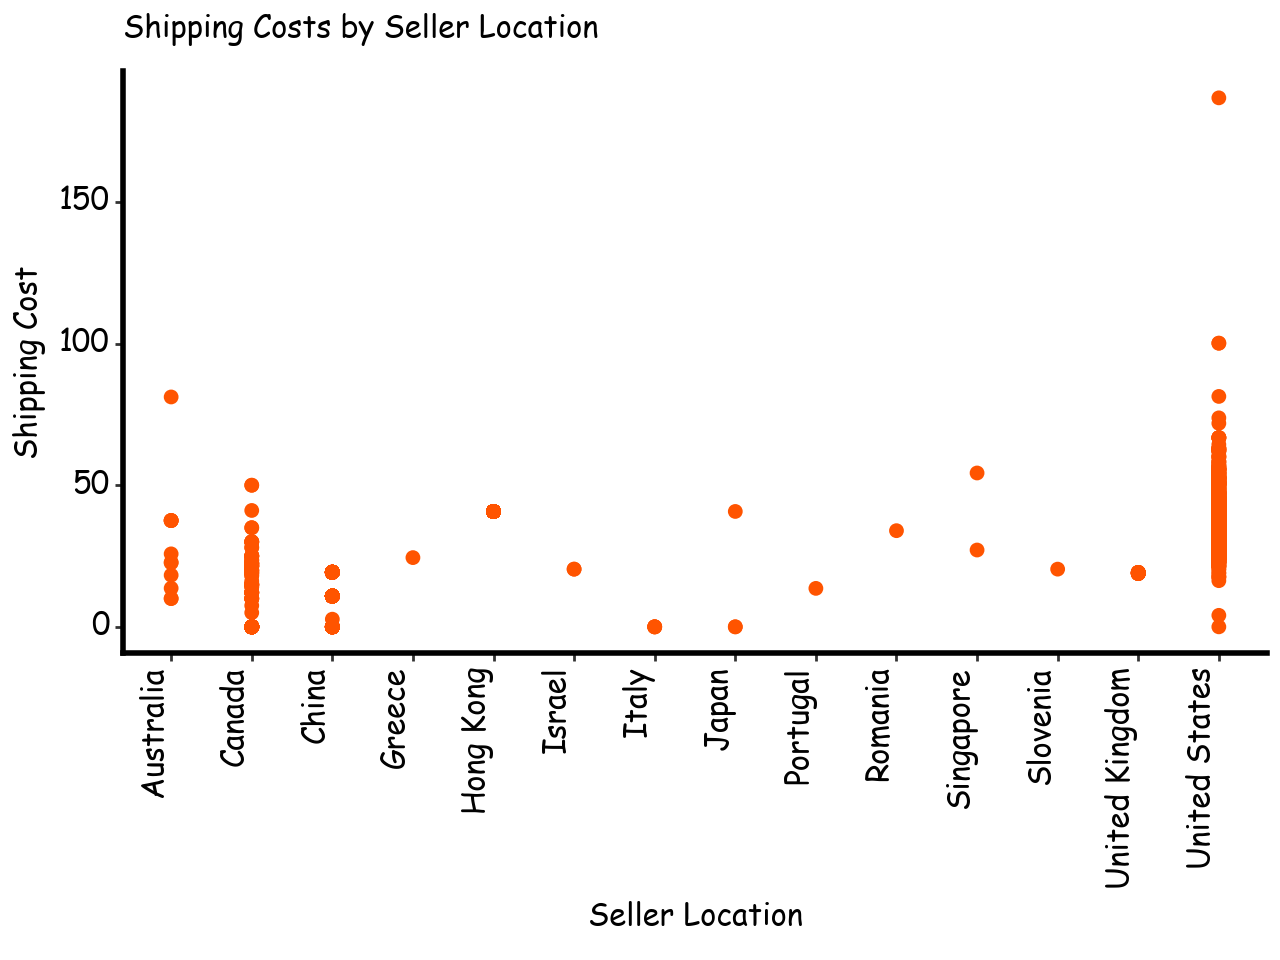

In [25]:
## Shipping according to country
# Create the scatter plot
scatter_plot = (
    p9.ggplot(df, p9.aes(x='Seller_location', y='Shipping'))
    + p9.geom_point(color="#ff5400", size=2)  # Points style
    + p9.xlab("Seller Location")  # X-axis label
    + p9.ylab("Shipping Cost")  # Y-axis label
    + p9.ggtitle("Shipping Costs by Seller Location")  # Title
    + p9.theme(
        axis_line=p9.element_line(size=2, color="black"),  # Axis line properties
        panel_grid_major=p9.element_blank(),  # Major grid lines
        panel_grid_minor=p9.element_blank(),  # Minor grid lines
        panel_border=p9.element_blank(),  # Panel border
        panel_background=p9.element_blank(),  # Panel background
        plot_title=p9.element_text(font="cursive"),  # Title font properties
        text=p9.element_text(font="cursive"),  # Text font properties
        axis_text_x=p9.element_text(color="black", rotation=90, ha='right'),  # X-axis text with rotation
        axis_text_y=p9.element_text(color="black")  # Y-axis text color
    )
)

# Display the scatter plot
print(scatter_plot)


In [26]:
# Assuming df is your dataframe
unique_conditions = df['Condition'].unique()

# Print the unique values
print(unique_conditions)


['Pre-Owned' 'Good - Refurbished' 'Open Box' 'Very Good - Refurbished'
 'Parts Only' 'Excellent - Refurbished' 'New (Other)' 'Brand New']


In [27]:
df.columns

Index(['iPhone', 'Condition', 'Price', 'Shipping', 'Seller_stars',
       'Seller_location', 'iPhone_lower', 'Seller_name', 'Seller_reviews',
       'Seller_rating', 'Storage', 'Color', 'Model', 'Carrier_Status',
       'Total_Price'],
      dtype='object')

In [28]:
## Selecting relevant columns
df = df[['Condition', 'Seller_location', 'Seller_reviews', 'Seller_rating', 'Storage', 'Carrier_Status', 'Model','Price','Shipping']].copy()
print(df.columns)
df['Storage'] = df['Storage'].astype('int32')
print(df.dtypes)

Index(['Condition', 'Seller_location', 'Seller_reviews', 'Seller_rating',
       'Storage', 'Carrier_Status', 'Model', 'Price', 'Shipping'],
      dtype='object')
Condition           object
Seller_location     object
Seller_reviews     float64
Seller_rating      float64
Storage              int32
Carrier_Status      object
Model               object
Price              float64
Shipping           float64
dtype: object


In [29]:
## Pre-process
# Assuming df is your dataframe
df = df[['Condition', 'Seller_location', 'Carrier_Status', 'Model', 'Price', 'Storage', 'Shipping', 'Seller_reviews', 'Seller_rating']]

# Ordinal Encoding for Condition
condition_categories = ['Pre-Owned', 'Good - Refurbished', 'Open Box', 'Very Good - Refurbished', 'Parts Only', 'Excellent - Refurbished', 'New (Other)', 'Brand New']
condition_order_dict = {category: i for i, category in enumerate(condition_categories)}
df['Condition'] = df['Condition'].map(condition_order_dict)

# Ordinal Encoding for Model
model_order = ['11', '11 Pro', '11 Pro Max']
model_categories = df['Model'].unique()

if set(model_order) == set(model_categories):
    df['Model'] = df['Model'].astype('category').cat.reorder_categories(model_order).cat.codes
else:
    print(f"Error: The model categories in the dataframe ({model_categories}) do not match the expected categories ({model_order}).")

# Ordinal Encoding for Seller_location and Carrier_Status
le = LabelEncoder()
df['Seller_location'] = le.fit_transform(df['Seller_location'])
df['Carrier_Status'] = le.fit_transform(df['Carrier_Status'])

# Convert Storage to int32
df['Storage'] = df['Storage'].astype('int32')

# Standardize the numerical columns: 'Seller_reviews' and 'Seller_rating'
scaler = StandardScaler()
df[['Seller_reviews', 'Seller_rating']] = scaler.fit_transform(df[['Seller_reviews', 'Seller_rating']])
print(df.head())

   Condition  Seller_location  Carrier_Status  Model   Price  Storage  \
2          0                1               1      0  268.99       64   
3          0               13               1      0  270.23       64   
4          0               13               0      0  224.05       64   
5          1               13               1      1  325.89       64   
7          2                1               0      0  199.00       64   

   Shipping  Seller_reviews  Seller_rating  
2      0.00       -0.473700       0.335098  
3     27.31        0.096700       0.335098  
4     25.81        2.211991       0.357995  
5     29.02        2.211991       0.357995  
7      0.00       -0.463370       0.433228  


In [30]:
## Model selection

# Assuming df has been preprocessed and is ready for modeling

# Separate features and target variables
X = df.drop(columns=['Price', 'Shipping'])  # Features (all columns except 'Price' and 'Shipping')
y_price = df['Price']  # Target variable for Price
y_shipping = df['Shipping']  # Target variable for Shipping

# Split the data for Price model (80% train, 20% test)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X, y_price, test_size=0.2, random_state=42)

# Split the data for Shipping model (80% train, 20% test)
X_train_shipping, X_test_shipping, y_train_shipping, y_test_shipping = train_test_split(X, y_shipping, test_size=0.2, random_state=42)

# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Adjusted R-squared function
def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

# To store results
results = {}

# Train and evaluate models for Price and Shipping
for name, model in models.items():
    # Train model for Price
    model.fit(X_train_price, y_train_price)
    y_pred_price = model.predict(X_test_price)
    
    # Calculate metrics for Price
    price_mse = mean_squared_error(y_test_price, y_pred_price)
    price_rmse = np.sqrt(price_mse)
    price_r2 = r2_score(y_test_price, y_pred_price)
    
    # Adjusted R-squared for Price
    n_price = X_test_price.shape[0]  # Number of samples in test set
    k_price = X_test_price.shape[1]  # Number of features
    price_adj_r2 = adjusted_r2(price_r2, n_price, k_price)
    
    # Train model for Shipping
    model.fit(X_train_shipping, y_train_shipping)
    y_pred_shipping = model.predict(X_test_shipping)
    
    # Calculate metrics for Shipping
    shipping_mse = mean_squared_error(y_test_shipping, y_pred_shipping)
    shipping_rmse = np.sqrt(shipping_mse)
    shipping_r2 = r2_score(y_test_shipping, y_pred_shipping)
    
    # Adjusted R-squared for Shipping
    n_shipping = X_test_shipping.shape[0]  # Number of samples in test set
    k_shipping = X_test_shipping.shape[1]  # Number of features
    shipping_adj_r2 = adjusted_r2(shipping_r2, n_shipping, k_shipping)
    
    # Store results for both Price and Shipping models
    results[name] = {
        'Price_RMSE': price_rmse,
        'Price_R2': price_r2,
        'Price_Adjusted_R2': price_adj_r2,
        'Shipping_RMSE': shipping_rmse,
        'Shipping_R2': shipping_r2,
        'Shipping_Adjusted_R2': shipping_adj_r2
    }

# Output the results
for name, metrics in results.items():
    print(f"Results for {name}:")
    print(f"  Price Model -> RMSE: {metrics['Price_RMSE']}, R^2: {metrics['Price_R2']}, Adjusted R^2: {metrics['Price_Adjusted_R2']}")
    print(f"  Shipping Model -> RMSE: {metrics['Shipping_RMSE']}, R^2: {metrics['Shipping_R2']}, Adjusted R^2: {metrics['Shipping_Adjusted_R2']}")


Results for LinearRegression:
  Price Model -> RMSE: 102.79598072034938, R^2: 0.41722499573136074, Adjusted R^2: 0.4087964316200374
  Shipping Model -> RMSE: 9.728743433873511, R^2: 0.40216063461271667, Adjusted R^2: 0.39351419751000793
Results for RandomForest:
  Price Model -> RMSE: 76.99599477296677, R^2: 0.6730473088388476, Adjusted R^2: 0.668318654214616
  Shipping Model -> RMSE: 7.589071483817029, R^2: 0.6362120623756692, Adjusted R^2: 0.6309506665835818
Results for XGBoost:
  Price Model -> RMSE: 73.03391165574511, R^2: 0.7058304125866577, Adjusted R^2: 0.7015758937604317
  Shipping Model -> RMSE: 7.899921763075357, R^2: 0.6058000289018368, Adjusted R^2: 0.6000987896504171


In [31]:
## Feature selection
# Define the features used for Price and Shipping models
price_features = ['Condition', 'Model', 'Storage', 'Seller_reviews', 'Seller_rating', 'Seller_location', 'Carrier_Status']
shipping_features = ['Condition', 'Model', 'Storage', 'Seller_reviews', 'Seller_rating', 'Seller_location', 'Carrier_Status']

# Separate categorical and numerical features
categorical_features = ['Condition', 'Model', 'Storage', 'Carrier_Status', 'Seller_location']
numerical_features = ['Seller_reviews', 'Seller_rating']

# Create preprocessing pipeline for both models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Function to calculate p-values
def calculate_p_values(X, y):
    model = sm.OLS(y, X).fit()
    return pd.Series(model.pvalues, index=X.columns)

# For Price model
X_price = df[price_features]
y_price = df['Price']

# Preprocess the data for the Price model
X_price_processed = preprocessor.fit_transform(X_price)
feature_names_price = (numerical_features +
                       preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist())

# Reset indices to ensure alignment
X_price_processed_df = pd.DataFrame(X_price_processed, columns=feature_names_price).reset_index(drop=True)
y_price = y_price.reset_index(drop=True)

# Calculate p-values for Price model
p_values_price = calculate_p_values(X_price_processed_df, y_price)
print("P-values for Price model:")
print(p_values_price)

# Filter columns with p-values less than 0.05 and store them in a list
significant_price_features = p_values_price[p_values_price < 0.05].index.tolist()
print("\nSignificant features for Price model (p-values < 0.05):")
print(significant_price_features)

# For Shipping model
X_shipping = df[shipping_features]
y_shipping = df['Shipping']

# Preprocess the data for the Shipping model using the same preprocessor
X_shipping_processed = preprocessor.transform(X_shipping)
# Use the same feature names since we used the same preprocessor
feature_names_shipping = feature_names_price  # Reuse feature names from Price model

# Reset indices to ensure alignment
X_shipping_processed_df = pd.DataFrame(X_shipping_processed, columns=feature_names_shipping).reset_index(drop=True)
y_shipping = y_shipping.reset_index(drop=True)

# Calculate p-values for Shipping model
p_values_shipping = calculate_p_values(X_shipping_processed_df, y_shipping)
print("\nP-values for Shipping model:")
print(p_values_shipping)

# Filter columns with p-values less than 0.05 and store them in a list
significant_shipping_features = p_values_shipping[p_values_shipping < 0.05].index.tolist()
print("\nSignificant features for Shipping model (p-values < 0.05):")
print(significant_shipping_features)

# The two lists with significant features
print("\nFinal lists:")
print("Significant features for Price model:", significant_price_features)
print("Significant features for Shipping model:", significant_shipping_features)


P-values for Price model:
Seller_reviews         2.870926e-13
Seller_rating          1.127550e-05
Condition_1            1.469432e-03
Condition_2            1.555705e-01
Condition_3            1.222761e-06
Condition_4            5.236468e-37
Condition_5            9.594815e-18
Condition_6            2.473618e-44
Condition_7            1.670194e-74
Model_1                4.086112e-46
Model_2               1.061936e-113
Storage_128            1.248528e-12
Storage_256            3.851966e-28
Storage_512            3.277101e-16
Carrier_Status_1       4.304748e-15
Seller_location_1     2.821399e-172
Seller_location_2     1.011469e-109
Seller_location_3      1.436113e-02
Seller_location_4      4.719855e-71
Seller_location_5      1.548002e-03
Seller_location_6      1.652642e-25
Seller_location_7      1.889820e-07
Seller_location_8      9.031213e-06
Seller_location_9      1.717760e-03
Seller_location_10     8.083417e-12
Seller_location_11     2.402664e-03
Seller_location_12    1.738253e-101
Se

In [32]:
print("DataFrame columns:", df.columns.tolist())

DataFrame columns: ['Condition', 'Seller_location', 'Carrier_Status', 'Model', 'Price', 'Storage', 'Shipping', 'Seller_reviews', 'Seller_rating']


In [34]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Define the features based on your analysis
significant_price_features = ['Seller_reviews', 'Seller_rating', 'Condition', 'Model', 'Storage', 'Carrier_Status', 'Seller_location']
significant_shipping_features = ['Seller_reviews', 'Condition', 'Model', 'Storage', 'Seller_location']

# Step 2: Create preprocessing steps for Price and Shipping models
price_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Seller_reviews', 'Seller_rating']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Condition', 'Model', 'Storage', 'Carrier_Status', 'Seller_location'])
    ])

shipping_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Seller_reviews']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Condition', 'Model', 'Storage', 'Seller_location'])
    ])

# Step 3: Define the parameter grids for GridSearchCV
price_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [None, 10, 20],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__min_child_weight': [1, 2],
    'xgb__subsample': [0.8, 1.0]
}

shipping_param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Step 4: Create pipelines for Price and Shipping models
price_pipeline = Pipeline([
    ('preprocessor', price_preprocessor),
    ('xgb', XGBRegressor(random_state=42))
])

shipping_pipeline = Pipeline([
    ('preprocessor', shipping_preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

# Step 5: Split the data into training and testing sets for Price model
X_price = df[significant_price_features]
y_price = df['Price']
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

# Step 6: Perform GridSearchCV for Price model
price_grid_search = GridSearchCV(price_pipeline, price_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
price_grid_search.fit(X_price_train, y_price_train)

# Step 7: Split the data into training and testing sets for Shipping model
X_shipping = df[significant_shipping_features]
y_shipping = df['Shipping']
X_shipping_train, X_shipping_test, y_shipping_train, y_shipping_test = train_test_split(X_shipping, y_shipping, test_size=0.2, random_state=42)

# Step 8: Perform GridSearchCV for Shipping model
shipping_grid_search = GridSearchCV(shipping_pipeline, shipping_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
shipping_grid_search.fit(X_shipping_train, y_shipping_train)

# Step 9: Get the best models
best_price_model = price_grid_search.best_estimator_
best_shipping_model = shipping_grid_search.best_estimator_

# Step 10: Make predictions on the test data for both models
y_price_pred = best_price_model.predict(X_price_test)
y_shipping_pred = best_shipping_model.predict(X_shipping_test)

# Step 11: Evaluation metrics for Price model
price_rmse = mean_squared_error(y_price_test, y_price_pred, squared=False)
price_r2 = r2_score(y_price_test, y_price_pred)

# Evaluation metrics for Shipping model
shipping_rmse = mean_squared_error(y_shipping_test, y_shipping_pred, squared=False)
shipping_r2 = r2_score(y_shipping_test, y_shipping_pred)

# Number of observations and predictors for Adjusted R² calculation
n_price = X_price_test.shape[0]
n_shipping = X_shipping_test.shape[0]
k_price = X_price_test.shape[1]
k_shipping = X_shipping_test.shape[1]

# Adjusted R² calculation for Price and Shipping models
price_adj_r2 = 1 - ((1 - price_r2) * (n_price - 1)) / (n_price - k_price - 1)
shipping_adj_r2 = 1 - ((1 - shipping_r2) * (n_shipping - 1)) / (n_shipping - k_shipping - 1)

# Output the results
print("Best hyperparameters for Price model:", price_grid_search.best_params_)
print(f"XGBoost Price Model RMSE: {price_rmse}, R2: {price_r2}, Adjusted R2: {price_adj_r2}")

print("\nBest hyperparameters for Shipping model:", shipping_grid_search.best_params_)
print(f"Random Forest Shipping Model RMSE: {shipping_rmse}, R2: {shipping_r2}, Adjusted R2: {shipping_adj_r2}")


Best hyperparameters for Price model: {'xgb__learning_rate': 0.1, 'xgb__max_depth': None, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
XGBoost Price Model RMSE: 72.64967722008117, R2: 0.7089175471758347, Adjusted R2: 0.7047076769903612

Best hyperparameters for Shipping model: {'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Random Forest Shipping Model RMSE: 7.487505593540977, R2: 0.6458841815622949, Adjusted R2: 0.6422410147059399


In [35]:
## Saving model

# Assuming you have the trained models as follows:
best_price_model = price_grid_search.best_estimator_
best_shipping_model = shipping_grid_search.best_estimator_

# Step 1: Save the trained XGBoost models
joblib.dump(best_price_model, "models/best_price_model.pkl")
joblib.dump(best_shipping_model, "models/best_shipping_model.pkl")

# Step 2: Sample data to fit LabelEncoders (ensure all lists have the same length)
sample_data = pd.DataFrame({
    'Condition': ['Brand New', 'New (Other)', 'Open Box', 'Excellent - Refurbished', 'Very Good - Refurbished', 'Good - Refurbished', 'Pre-Owned', 'Parts Only'],
    'Seller_location': ['Canada', 'United States', 'Italy', 'Japan', 'Australia', 'France', 'Croatia', 'Greece'],
    'Model': ['11', '11 Pro', '11 Pro Max', '11', '11 Pro', '11 Pro Max', '11', '11 Pro']
})

# Step 3: Initialize LabelEncoders
le_condition = LabelEncoder()
le_location = LabelEncoder()
le_model = LabelEncoder()

# Step 4: Fit LabelEncoders
le_condition.fit(sample_data['Condition'])
le_location.fit(sample_data['Seller_location'])
le_model.fit(sample_data['Model'])

# Step 5: Save the LabelEncoders
joblib.dump(le_condition, "variables/le_condition.pkl")
joblib.dump(le_location, "variables/le_location.pkl")
joblib.dump(le_model, "variables/le_model.pkl")

print("Models and LabelEncoders saved successfully.")


Models and LabelEncoders saved successfully.
